<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment_02_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>






<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [107]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [108]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [109]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [110]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab environment

In [111]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## EDA Functions

In [112]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [113]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [114]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [115]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [116]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [117]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [118]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels 

In [119]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [120]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [121]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

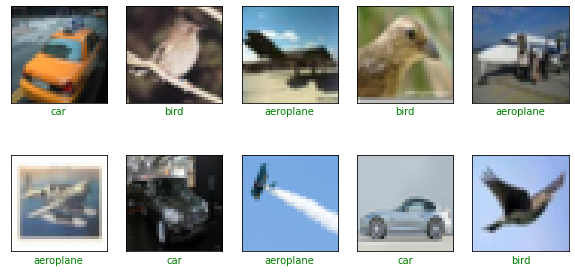

In [122]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [123]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [124]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [125]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [126]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

print(x_train_norm.shape, x_valid_norm.shape, x_test_norm.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


##Experiment 1: DNN with 2 layers (no regularization)

Hidden layer 1: 100 neurons

Hidden layer 2: 150 neurons

Ouput layer: 10 neurons (one for each image)

####Build, Compile, Train, Evaluate

In [127]:
## Variation 1 - did not train
#model_1 = Sequential()
#model_1.add(Dense(input_shape = [32,32,3], units = 100, activation = 'relu', ))
#model_1.add(Dense(units = 150, activation = 'relu'))
#model_1.add(Dense(name = "output_layer", units = 10, activation = 'softmax'))
#model_1.summary()

In [128]:
## Variation 2 - trained 
model_1 = Sequential()
model_1.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_1.add(layers.Dense(units = 100, activation = "relu"))
model_1.add(layers.Dense(units = 150, activation = "relu"))
model_1.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 3072)              0         
                                                                 
 dense_18 (Dense)            (None, 100)               307300    
                                                                 
 dense_19 (Dense)            (None, 150)               15150     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 323,960
Trainable params: 323,960
Non-trainable params: 0
_________________________________________________________________


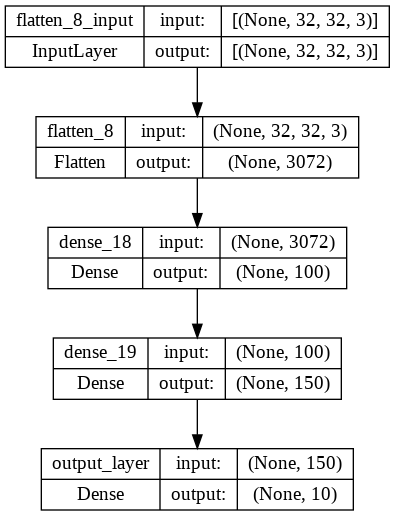

In [129]:
keras.utils.plot_model(model_1, "CIFAR_model.png", show_shapes=True) 

In [130]:
## Compile

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [131]:
## Train 

history_1 = model_1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_1.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 1.8696 - accuracy: 0.3250 - val_loss: 1.7315 - val_accuracy: 0.3710
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6951 - accuracy: 0.3884 - val_loss: 1.7190 - val_accuracy: 0.3760
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6213 - accuracy: 0.4213 - val_loss: 1.6646 - val_accuracy: 0.3922
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5703 - accuracy: 0.4384 - val_loss: 1.6362 - val_accuracy: 0.4146
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5383 - accuracy: 0.4515 - val_loss: 1.5609 - val_accuracy: 0.4364
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5109 - accuracy: 0.4584 - val_loss: 1.5782 - val_accuracy: 0.4354
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4867 - accuracy: 0.4682 - val_loss: 1.5530 - val_accuracy: 0.4422

In [132]:
## Evaluate

model_1 = tf.keras.models.load_model("DNN_model_1.h5")
print(f"Test acc: {model_1.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4407 - accuracy: 0.4923
Test acc: 0.492


#### Plot Metrics

In [133]:
history_dict_1 = history_1.history
history_dict_1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [134]:
history_df_1=pd.DataFrame(history_dict_1)
history_df_1.tail().round(3)

loss  accuracy  val_loss  val_accuracy
13  1.389     0.506     1.519         0.457
14  1.372     0.510     1.476         0.480
15  1.368     0.511     1.486         0.476
16  1.364     0.514     1.522         0.460
17  1.352     0.518     1.480         0.476

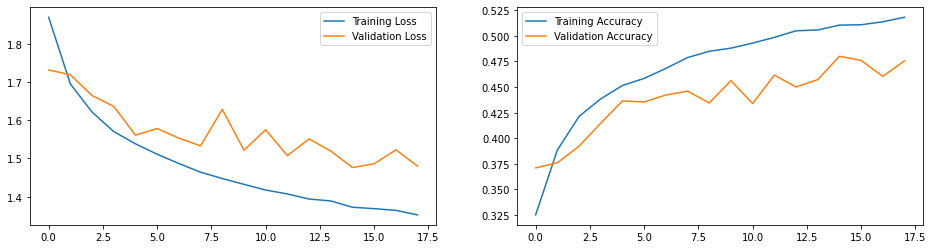

In [135]:
## Loss and acuracy
plot_history(history_1)

In [136]:
## Confusion matrix
pred_1= model_1.predict(x_test_norm)
pred_1=np.argmax(pred_1, axis=1)

313/313 [==============================] - 1s 4ms/step


313/313 [==============================] - 0s 1ms/step


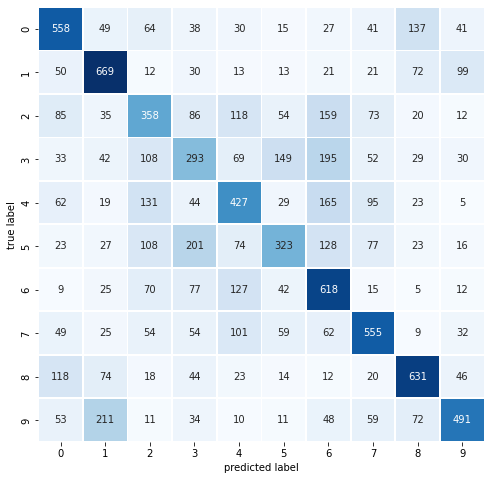

In [137]:
# Get the predicted classes:
pred_classes_1 = np.argmax(model_1.predict(x_test_norm), axis=-1)
pred_classes_1;

conf_mx_1 = tf.math.confusion_matrix(y_test, pred_classes_1)
conf_mx_1;

plot_confusion_matrix(y_test,pred_classes_1)

#### Activation and Performance

In [138]:
# Extracts the outputs of all layers:
layer_outputs_1 = [layer.output for layer in model_1.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_1 = models.Model(inputs=model_1.input, outputs=layer_outputs_1)

# Get activation values for the last dense layer
activations_1 = activation_model_1.predict(x_valid_norm[:3250])
dense_layer_activations_1 = activations_1[-3]
output_layer_activations_1 = activations_1[-1]

102/102 [==============================] - 0s 1ms/step


In [139]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_1 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_1 = tsne_1.fit_transform(dense_layer_activations_1)

# Scaling
tsne_results_1 = (tsne_results_1 - tsne_results_1.min()) / (tsne_results_1.max() - tsne_results_1.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 3250 samples in 0.283s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 4.752989
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.106842
[t-SNE] KL divergence after 300 iterations: 2.499393


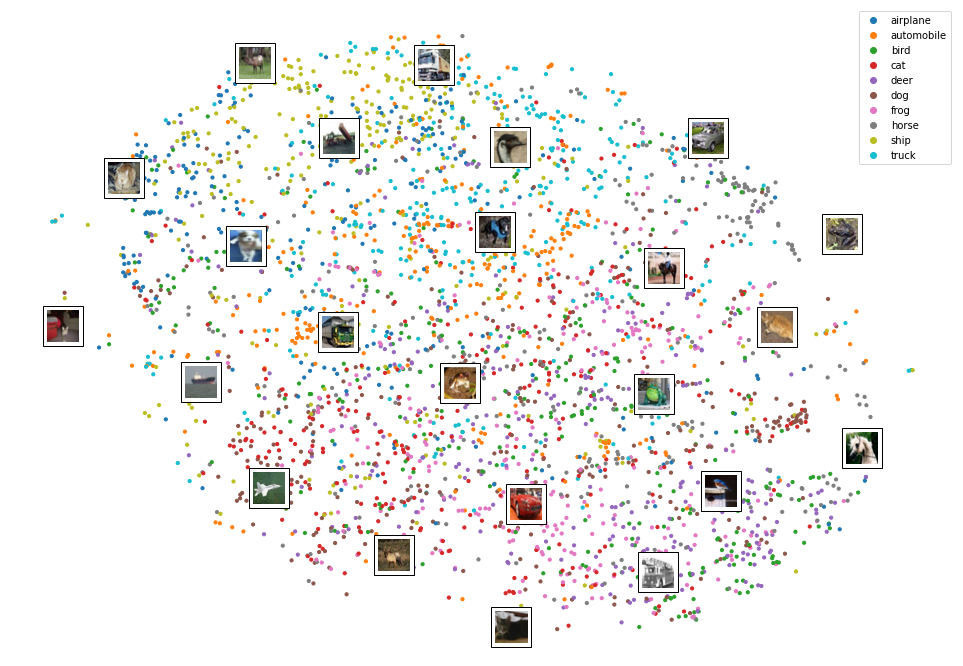

In [140]:
cmap_1 = plt.cm.tab10
plt.figure(figsize=(17,12))
scatter_1 = plt.scatter(tsne_results_1[:,0],tsne_results_1[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_1)
plt.legend(handles=scatter_1.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_1):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

##Experiment 2: DNN with 3 layers (no regularization)

Hidden layer 1: 100

Hidden layer 2: 150

Hidden layer 3: 75

Output layer: 10 (one for each image)

#### Build, Compile, Train, Evaluate

In [141]:
model_2 = Sequential()
model_2.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_2.add(layers.Dense(units = 100, activation = "relu"))
model_2.add(layers.Dense(units = 250, activation = "relu"))
model_2.add(layers.Dense(units = 150, activation = "relu"))
model_2.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 3072)              0         
                                                                 
 dense_20 (Dense)            (None, 100)               307300    
                                                                 
 dense_21 (Dense)            (None, 250)               25250     
                                                                 
 dense_22 (Dense)            (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


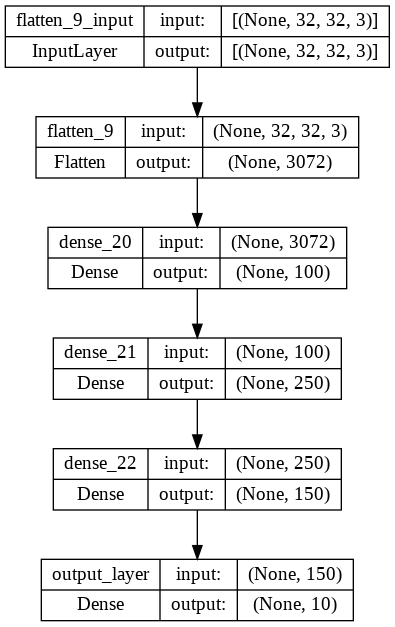

In [142]:
keras.utils.plot_model(model_2, "CIFAR_model.png", show_shapes=True) 

In [143]:
## Compile

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [144]:
## Train 

history_2 = model_2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 1.8549 - accuracy: 0.3294 - val_loss: 1.7449 - val_accuracy: 0.3666
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6729 - accuracy: 0.3966 - val_loss: 1.6464 - val_accuracy: 0.3992
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5958 - accuracy: 0.4253 - val_loss: 1.6256 - val_accuracy: 0.4136
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5500 - accuracy: 0.4466 - val_loss: 1.6413 - val_accuracy: 0.4090
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5043 - accuracy: 0.4618 - val_loss: 1.5665 - val_accuracy: 0.4304
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4792 - accuracy: 0.4705 - val_loss: 1.6265 - val_accuracy: 0.4210
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4404 - accuracy: 0.4844 - val_loss: 1.5407 - val_accuracy: 0.4504

In [145]:
## Evaluate

model_2 = tf.keras.models.load_model("DNN_model_2.h5")
print(f"Test acc: {model_2.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4409 - accuracy: 0.4898
Test acc: 0.490


#### Plot Metrics

In [146]:
history_dict_2 = history_2.history
history_dict_2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [147]:
history_df_2=pd.DataFrame(history_dict_2)
history_df_2.tail().round(3)

loss  accuracy  val_loss  val_accuracy
15  1.271     0.544     1.476         0.482
16  1.251     0.550     1.477         0.490
17  1.241     0.553     1.514         0.472
18  1.223     0.560     1.519         0.479
19  1.204     0.568     1.477         0.483

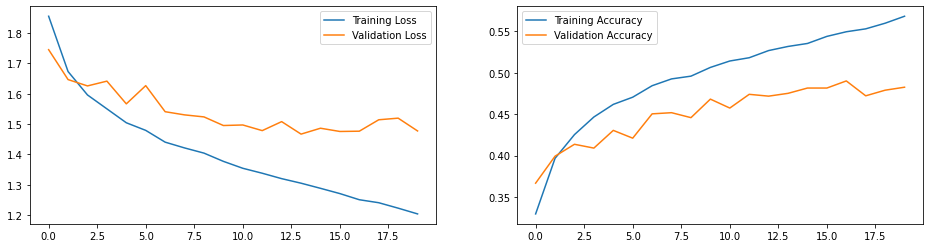

In [148]:
## Loss and acuracy
plot_history(history_2)

In [149]:
## Confusion matrix
pred_2= model_2.predict(x_test_norm)
pred_2=np.argmax(pred_2, axis=1)

313/313 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


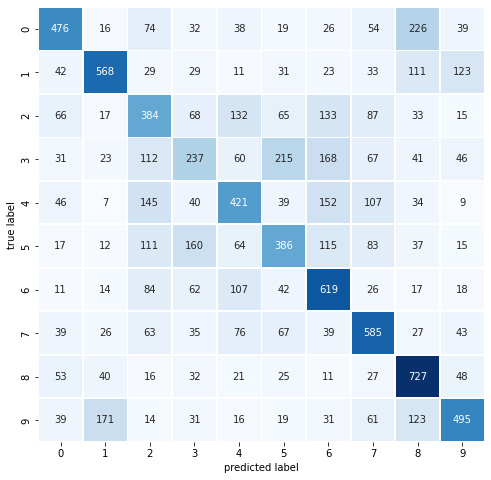

In [150]:
# Get the predicted classes:
pred_classes_2 = np.argmax(model_2.predict(x_test_norm), axis=-1)
pred_classes_2;

conf_mx_2 = tf.math.confusion_matrix(y_test, pred_classes_2)
conf_mx_2;

plot_confusion_matrix(y_test,pred_classes_2)

#### Activation and Performance

In [151]:
# Extracts the outputs of all layers:
layer_outputs_2 = [layer.output for layer in model_2.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_2 = models.Model(inputs=model_2.input, outputs=layer_outputs_2)

# Get activation values for the last dense layer
activations_2 = activation_model_2.predict(x_valid_norm[:3250])
dense_layer_activations_2 = activations_2[-3]
output_layer_activations_2 = activations_2[-1]

102/102 [==============================] - 0s 2ms/step


In [152]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_2 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_2 = tsne_2.fit_transform(dense_layer_activations_2)

# Scaling
tsne_results_2 = (tsne_results_2 - tsne_results_2.min()) / (tsne_results_2.max() - tsne_results_2.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.002s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 3250 samples in 0.311s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 3.323714
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.520805
[t-SNE] KL divergence after 300 iterations: 2.313845


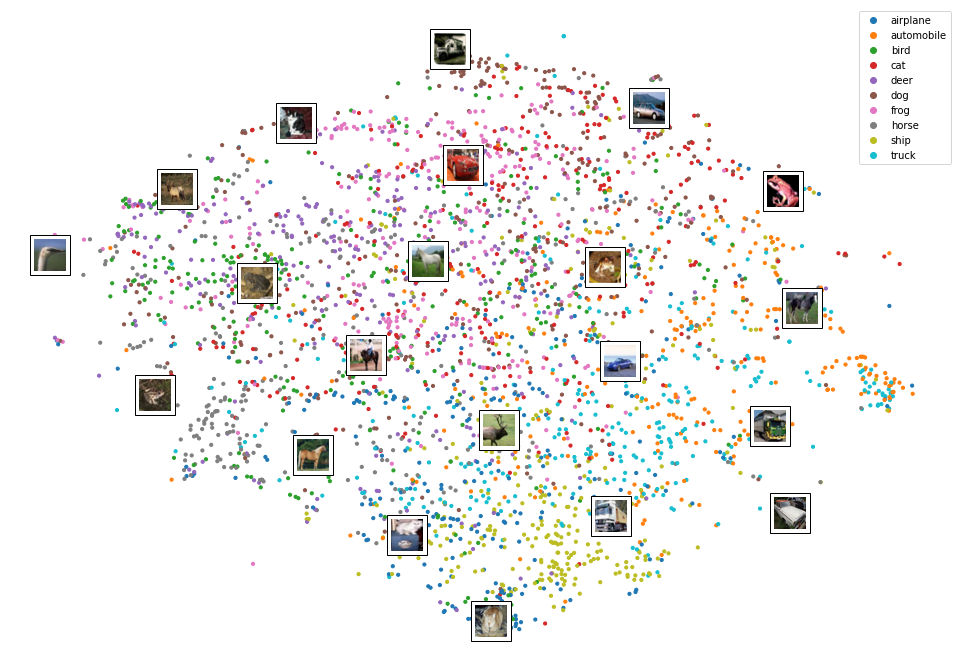

In [153]:
cmap_2 = plt.cm.tab10
plt.figure(figsize=(17,12))
scatter_2 = plt.scatter(tsne_results_2[:,0],tsne_results_2[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_2)
plt.legend(handles=scatter_2.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_2):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

##Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

Layer 1: 128

Layer 2: 256

Layer: 384

#### Build, Compile, Train, Evaluate

In [154]:
## Build CNN

model_3 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 9216)              0         
                                                                 
 dense_23 (Dense)            (None, 384)             

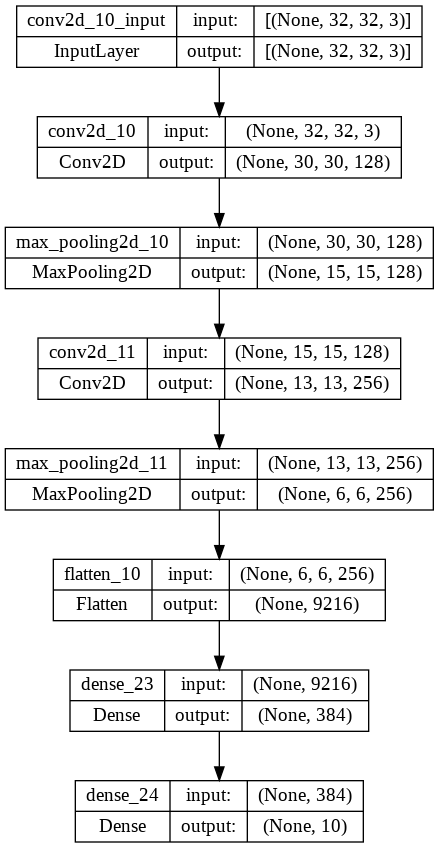

In [155]:
keras.utils.plot_model(model_3, "CIFAR10.png", show_shapes=True) 

In [156]:
## Compile

model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [157]:
## Train 

history_3 = model_3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_3.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 8s 10ms/step - loss: 2.1556 - accuracy: 0.2059 - val_loss: 2.0115 - val_accuracy: 0.2372
Epoch 2/200
704/704 [==============================] - 7s 10ms/step - loss: 1.9524 - accuracy: 0.2432 - val_loss: 1.8875 - val_accuracy: 0.2550
Epoch 3/200
704/704 [==============================] - 7s 10ms/step - loss: 1.8359 - accuracy: 0.2935 - val_loss: 1.7758 - val_accuracy: 0.3094
Epoch 4/200
704/704 [==============================] - 7s 10ms/step - loss: 1.7111 - accuracy: 0.3483 - val_loss: 1.6656 - val_accuracy: 0.3470
Epoch 5/200
704/704 [==============================] - 7s 10ms/step - loss: 1.6191 - accuracy: 0.3793 - val_loss: 1.5888 - val_accuracy: 0.3778
Epoch 6/200
704/704 [==============================] - 7s 10ms/step - loss: 1.5409 - accuracy: 0.4043 - val_loss: 1.5296 - val_accuracy: 0.3956
Epoch 7/200
704/704 [==============================] - 7s 10ms/step - loss: 1.4885 - accuracy: 0.4185 - val_loss: 1.5224 - val_accuracy:

In [158]:
## Evaluate

model_3 = tf.keras.models.load_model("CNN_model_3.h5")
print(f"Test acc: {model_3.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.1808 - accuracy: 0.6020
Test acc: 0.602


#### Plot Metrics

In [159]:
history_dict_3 = history_3.history
history_dict_3.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [160]:
history_df_3=pd.DataFrame(history_dict_3)
history_df_3.tail().round(3)

loss  accuracy  val_loss  val_accuracy
15  0.994     0.646     1.169         0.596
16  0.953     0.664     1.151         0.604
17  0.908     0.681     1.155         0.598
18  0.878     0.695     1.197         0.582
19  0.849     0.706     1.150         0.603

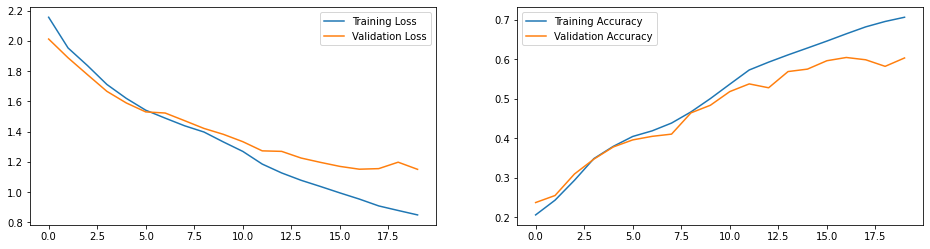

In [161]:
## Loss and acuracy
plot_history(history_3)

In [162]:
## Confusion matrix
pred_3= model_3.predict(x_test_norm)
pred_3=np.argmax(pred_3, axis=1)

313/313 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


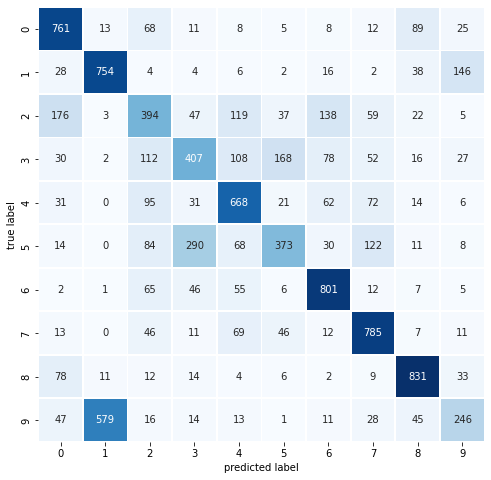

In [163]:
# Get the predicted classes:
pred_classes_3 = np.argmax(model_3.predict(x_test_norm), axis=-1)
pred_classes_3;

conf_mx_3 = tf.math.confusion_matrix(y_test, pred_classes_3)
conf_mx_3;

plot_confusion_matrix(y_test,pred_classes_3)

#### Activation and Performance

In [164]:
# Extracts the outputs of all layers:
layer_outputs_3 = [layer.output for layer in model_3.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_3 = models.Model(inputs=model_3.input, outputs=layer_outputs_3)

# Get activation values for the last dense layer
activations_3 = activation_model_3.predict(x_valid_norm[:3250])
dense_layer_activations_3 = activations_3[-3]
output_layer_activations_3 = activations_3[-1]

102/102 [==============================] - 0s 2ms/step


In [165]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_3 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_3 = tsne_3.fit_transform(dense_layer_activations_3)

# Scaling
tsne_results_3 = (tsne_results_3 - tsne_results_3.min()) / (tsne_results_3.max() - tsne_results_3.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.024s...
[t-SNE] Computed neighbors for 3250 samples in 2.685s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 4.147249
[t-SNE] KL divergence after 250 iterations with early exaggeration: 128.398773
[t-SNE] KL divergence after 300 iterations: 4.567607


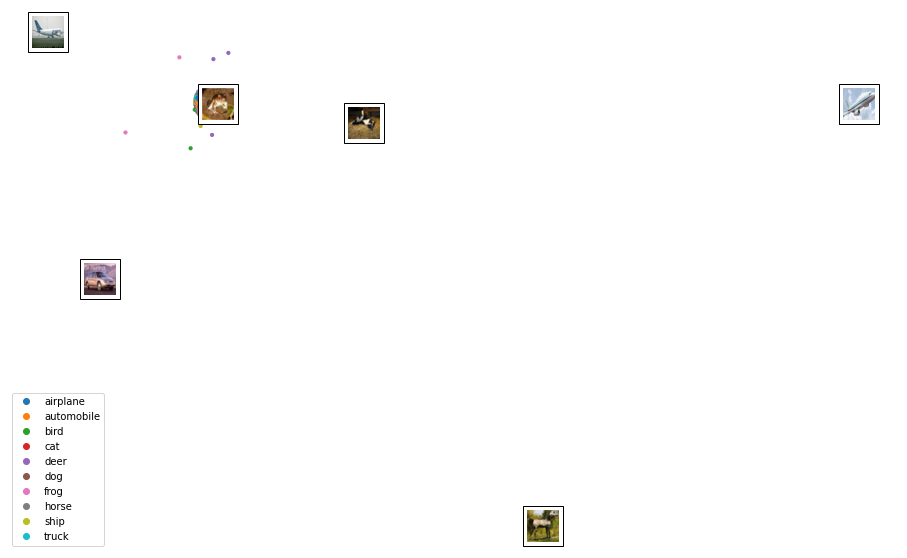

In [166]:
cmap_3 = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter_3 = plt.scatter(tsne_results_3[:,0],tsne_results_3[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_3)
plt.legend(handles=scatter_3.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_3):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#### Predictions

In [167]:
model_3 = tf.keras.models.load_model('CNN_model.h5')
preds_3 = model_3.predict(x_test_norm)
preds_3.shape

313/313 [==============================] - 1s 2ms/step


(10000, 10)

In [168]:
cm_3 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [169]:
df_3 = pd.DataFrame(preds_3[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df_3.style.format("{:.2%}").background_gradient(cmap=cm_3)

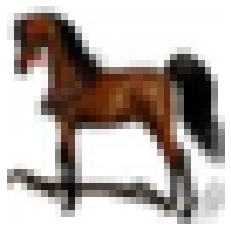

In [170]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img_3 = test_images[2004]
img_tensor_3 = image.img_to_array(img_3)
img_tensor_3 = np.expand_dims(img_tensor_3, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img_3, cmap='viridis')
plt.axis('off')
plt.show()

In [171]:
# Extracts the outputs of the top 8 layers:
layer_outputs_3 = [layer.output for layer in model_3.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_3 = models.Model(inputs=model_3.input, outputs=layer_outputs_3)

In [172]:
activations_3 = activation_model_3.predict(img_tensor_3)
len(activations_3)

1/1 [==============================] - 0s 78ms/step


7

In [173]:
layer_names = []
for layer in model_3.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten_2',
 'dense_5',
 'dense_6']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


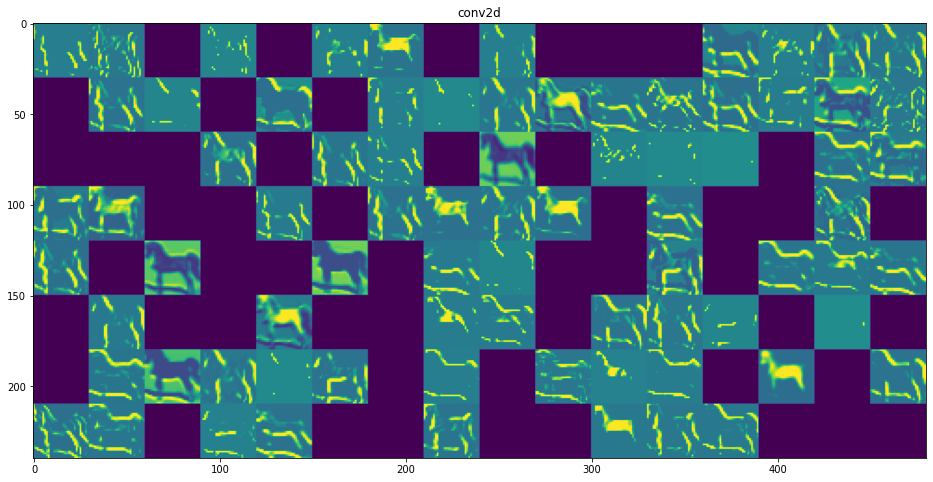

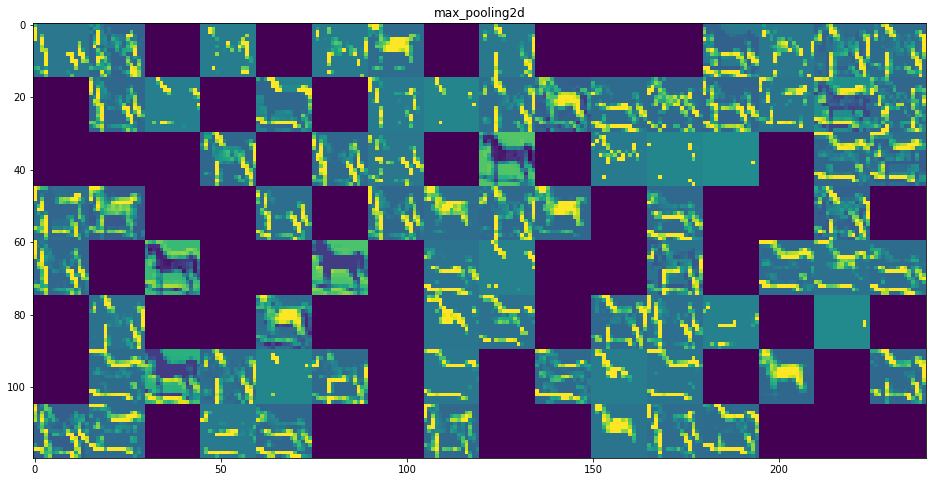

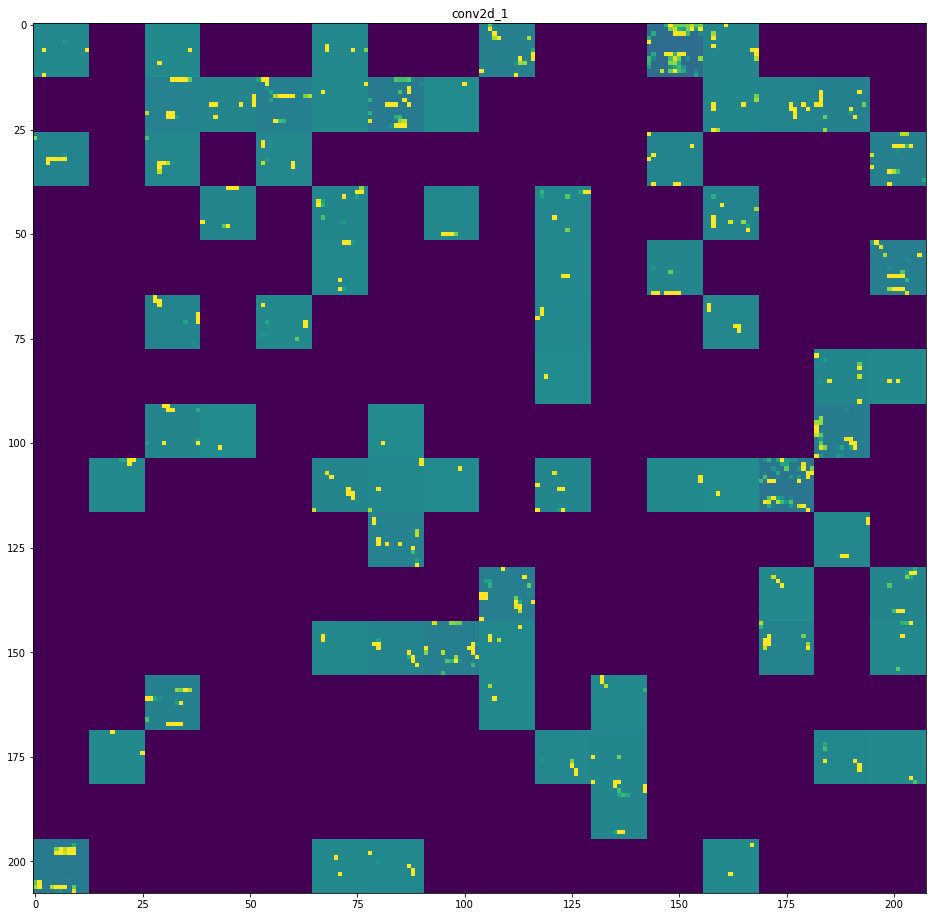

In [174]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_3.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_3):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

##Experiment 4: CNN with 2 convolution/max pooling layers (no regularization)

Layer 1: 128

Layer 2: 256

Layer 3: 512

Layer: 384

#### Build, Compile, Train, Evaluate

In [211]:
## Build CNN

model_4 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), #Start of Layer 1
  MaxPool2D((2, 2),strides=2), #End of Layer 1
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), #Start of Layer 2
  MaxPool2D((2, 2),strides=2), #End of Layer 2
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), #Start of Layer 3
  MaxPool2D((2, 2),strides=2), #End of Layer 3
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification
  BatchNormalization(),
  Dense(units=10, activation=tf.nn.softmax)       
])
model_4.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 2, 2, 512)      

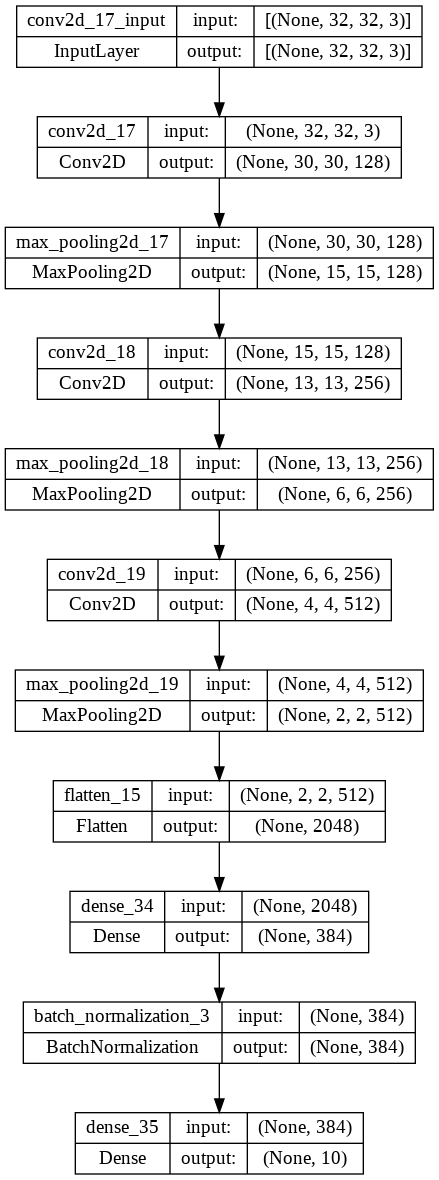

In [212]:
keras.utils.plot_model(model_4, "CIFAR10.png", show_shapes=True) 

In [213]:
## Compile
model_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [214]:
## Train
history_4 = model_4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_4.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 9s 12ms/step - loss: 1.5012 - accuracy: 0.4805 - val_loss: 1.3333 - val_accuracy: 0.5532
Epoch 2/200
704/704 [==============================] - 9s 12ms/step - loss: 1.0697 - accuracy: 0.6454 - val_loss: 1.0820 - val_accuracy: 0.6378
Epoch 3/200
704/704 [==============================] - 8s 12ms/step - loss: 0.8861 - accuracy: 0.7132 - val_loss: 1.0141 - val_accuracy: 0.6844
Epoch 4/200
704/704 [==============================] - 9s 12ms/step - loss: 0.7611 - accuracy: 0.7628 - val_loss: 0.8517 - val_accuracy: 0.7308
Epoch 5/200
704/704 [==============================] - 8s 12ms/step - loss: 0.6511 - accuracy: 0.8032 - val_loss: 0.8908 - val_accuracy: 0.7254
Epoch 6/200
704/704 [==============================] - 8s 12ms/step - loss: 0.5602 - accuracy: 0.8335 - val_loss: 0.9830 - val_accuracy: 0.7122
Epoch 7/200
704/704 [==============================] - 8s 12ms/step - loss: 0.4820 - accuracy: 0.8633 - val_loss: 0.9932 - val_accuracy:

In [215]:
## Evalute

model_4 = tf.keras.models.load_model("CNN_model_4.h5")
print(f"Test acc: {model_4.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.8820 - accuracy: 0.7226
Test acc: 0.723


#### Plot Metrics

In [216]:
history_dict_4 = history_4.history
history_dict_4.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [217]:
history_df_4=pd.DataFrame(history_dict_4)
history_df_4.tail().round(3)

loss  accuracy  val_loss  val_accuracy
2  0.886     0.713     1.014         0.684
3  0.761     0.763     0.852         0.731
4  0.651     0.803     0.891         0.725
5  0.560     0.833     0.983         0.712
6  0.482     0.863     0.993         0.718

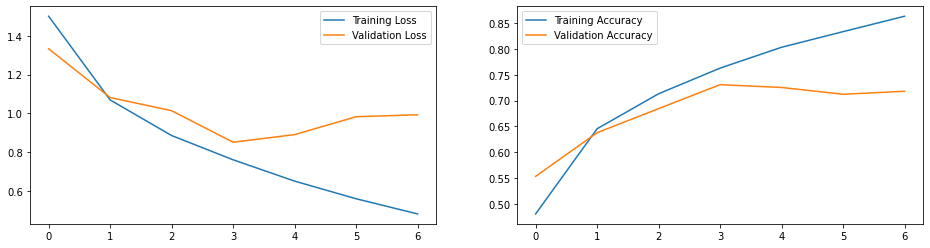

In [218]:
## Loss and acuracy
plot_history(history_4)

In [219]:
## Confusion matrix
pred_4= model_4.predict(x_test_norm)
pred_4=np.argmax(pred_4, axis=1)

313/313 [==============================] - 1s 3ms/step


313/313 [==============================] - 1s 3ms/step


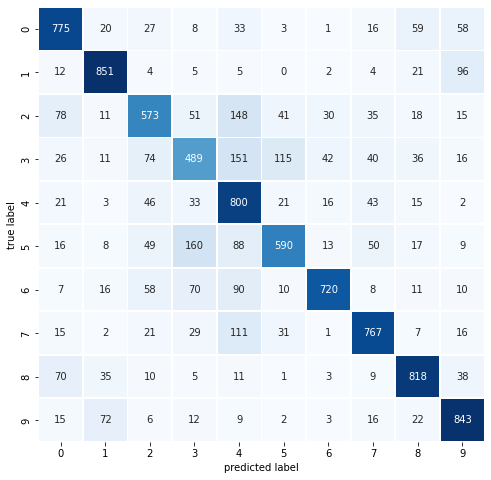

In [220]:
# Get the predicted classes:
pred_classes_4 = np.argmax(model_4.predict(x_test_norm), axis=-1)
pred_classes_4;

conf_mx_4 = tf.math.confusion_matrix(y_test, pred_classes_4)
conf_mx_4;

plot_confusion_matrix(y_test,pred_classes_4)

#### Activation and Performance

In [221]:
# Extracts the outputs of all layers:
layer_outputs_4 = [layer.output for layer in model_4.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_4 = models.Model(inputs=model_4.input, outputs=layer_outputs_4)

# Get activation values for the last dense layer
activations_4 = activation_model_4.predict(x_valid_norm[:3250])
dense_layer_activations_4 = activations_4[-3]
output_layer_activations_4 = activations_4[-1]

102/102 [==============================] - 0s 2ms/step


In [222]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_4 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_4 = tsne_3.fit_transform(dense_layer_activations_4)

# Scaling
tsne_results_3 = (tsne_results_3 - tsne_results_3.min()) / (tsne_results_3.max() - tsne_results_3.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.002s...
[t-SNE] Computed neighbors for 3250 samples in 0.493s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 0.052014
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.727036
[t-SNE] KL divergence after 300 iterations: 1.764962


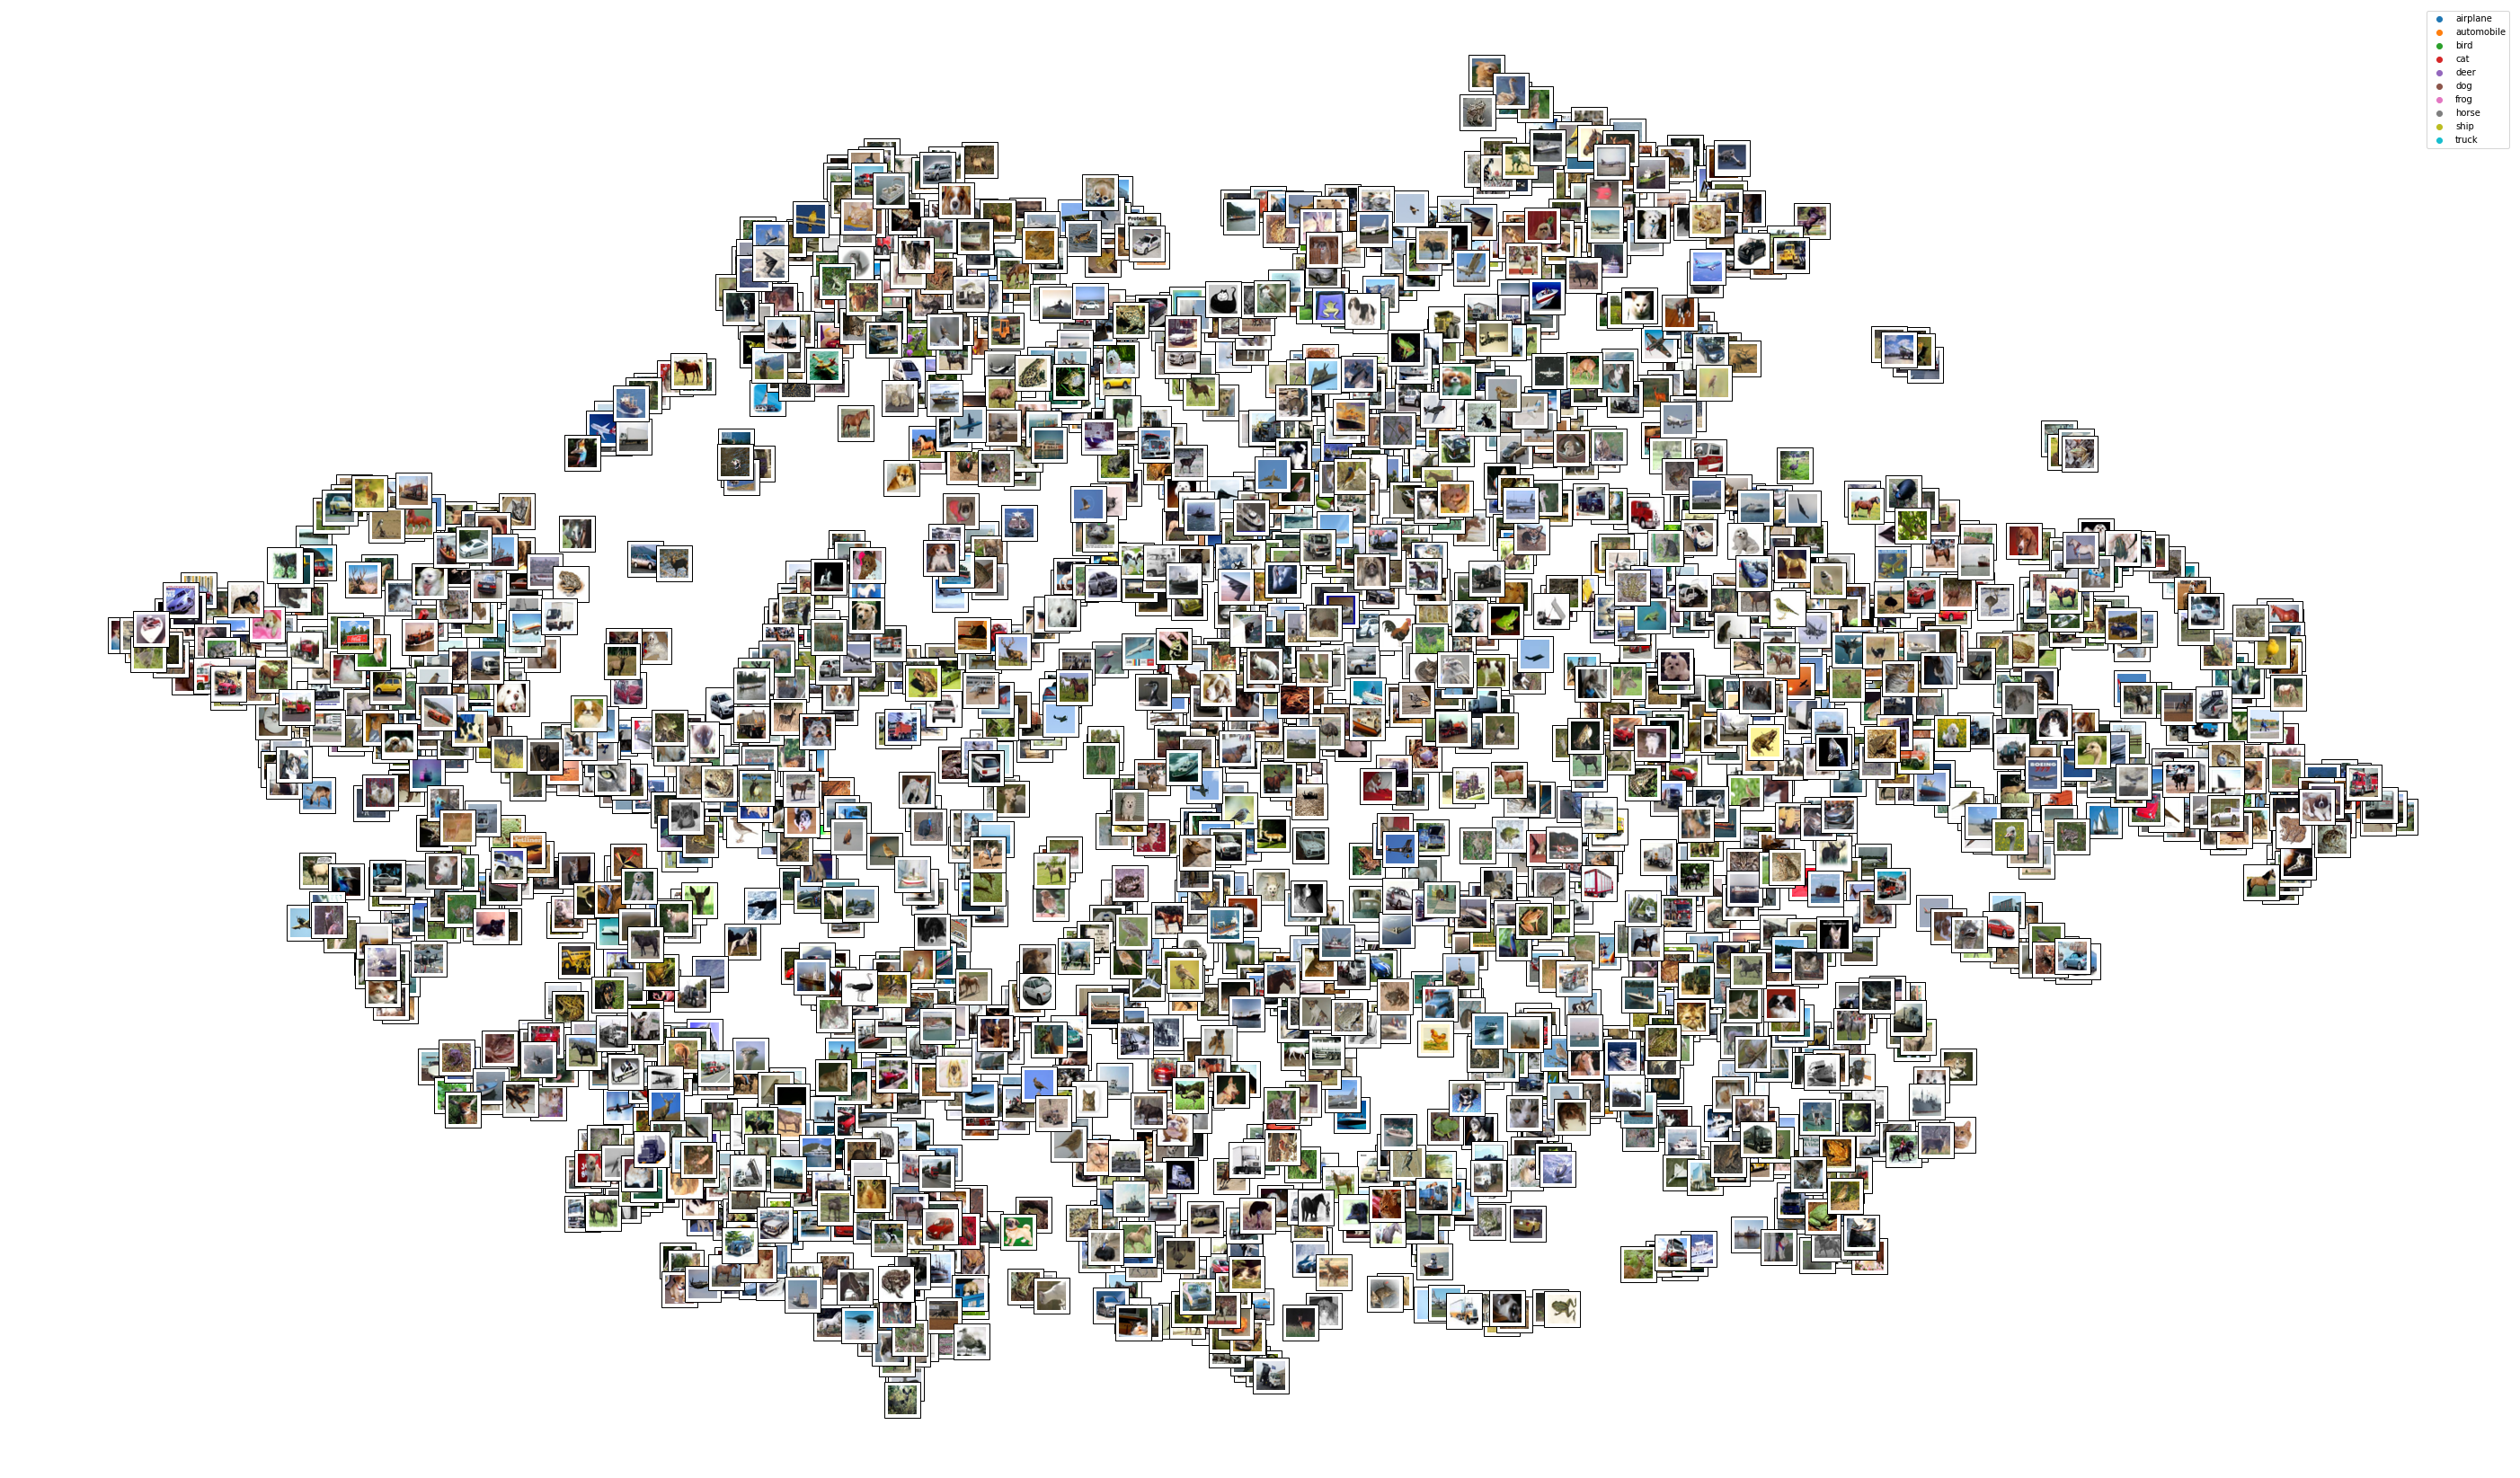

In [223]:
cmap_4 = plt.cm.tab10
plt.figure(figsize=(50,30))
scatter_4 = plt.scatter(tsne_results_4[:,0],tsne_results_4[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_4)
plt.legend(handles=scatter_4.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_4):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#### Predictions

In [224]:
model_4 = tf.keras.models.load_model('CNN_model.h5')
preds_4 = model_4.predict(x_test_norm)
preds_4.shape

313/313 [==============================] - 1s 2ms/step


(10000, 10)

In [225]:
cm_4 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [226]:
df_4= pd.DataFrame(preds_4[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df_4.style.format("{:.2%}").background_gradient(cmap=cm_4)

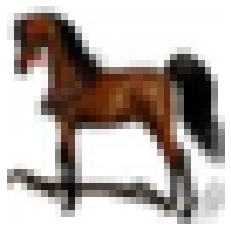

In [227]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img_4 = test_images[2004]
img_tensor_4 = image.img_to_array(img_4)
img_tensor_4 = np.expand_dims(img_tensor_4, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img_4, cmap='viridis')
plt.axis('off')
plt.show()

In [228]:
# Extracts the outputs of the top 8 layers:
layer_outputs_4 = [layer.output for layer in model_4.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_4 = models.Model(inputs=model_4.input, outputs=layer_outputs_4)

In [229]:
activations_4 = activation_model_4.predict(img_tensor_4)
len(activations_4)

1/1 [==============================] - 0s 67ms/step


7

In [230]:
layer_names = []
for layer in model_4.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten_2',
 'dense_5',
 'dense_6']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


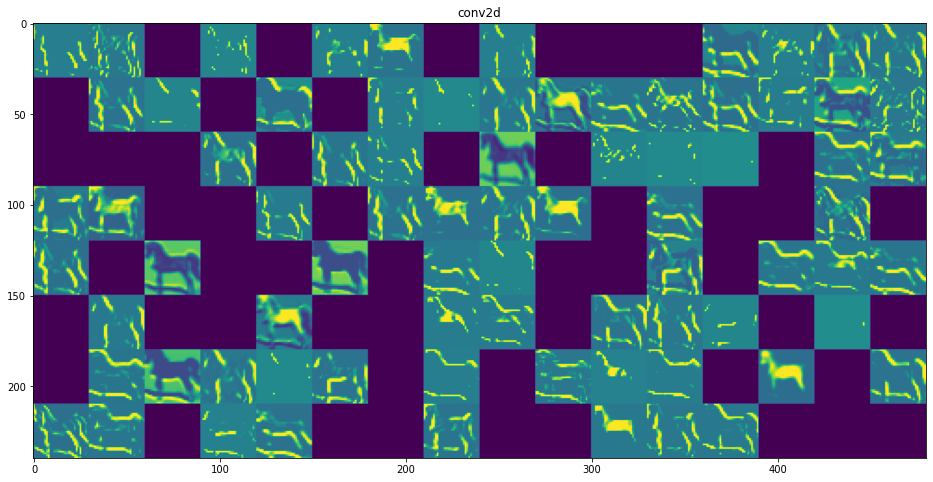

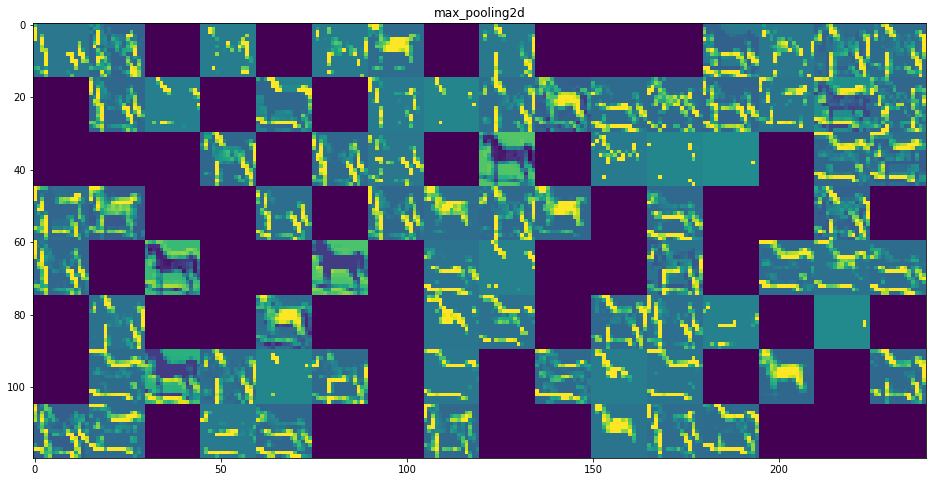

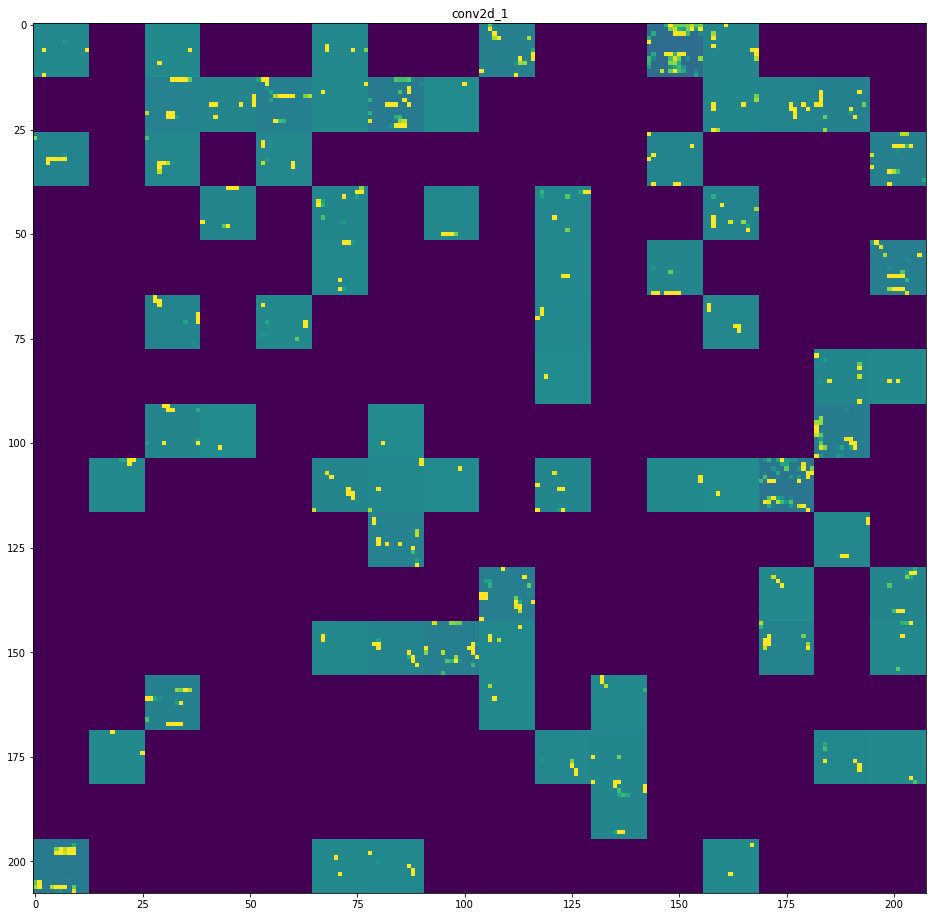

In [231]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_4.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_4):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

##Experiment 5: Experiments 1-4 with regularization 
https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

#### Model 5.1

Same as Model 1 with regularization

In [196]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_1 = Sequential()
model_5_1.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_1.add(layers.Dense(units = 100, activation = "relu"))
model_5_1.add(Dropout(0.25))
model_5_1.add(layers.Dense(units = 150, activation = "relu"))
model_5_1.add(Dropout(0.25))
model_5_1.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 3072)              0         
                                                                 
 dense_27 (Dense)            (None, 100)               307300    
                                                                 
 dropout_16 (Dropout)        (None, 100)               0         
                                                                 
 dense_28 (Dense)            (None, 150)               15150     
                                                                 
 dropout_17 (Dropout)        (None, 150)               0         
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 323,960
Trainable params: 323,960
Non-t

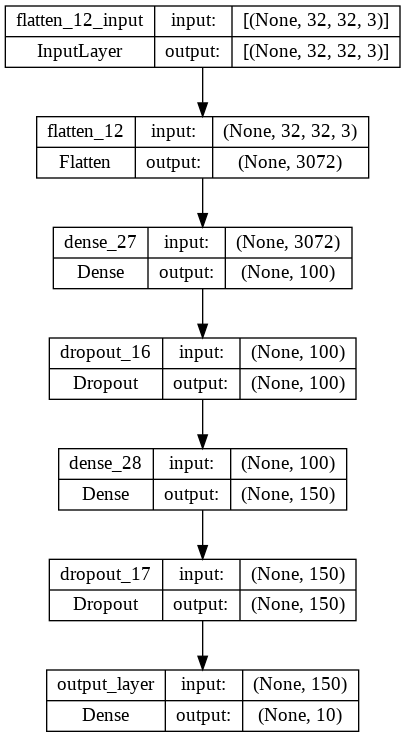

In [197]:
keras.utils.plot_model(model_5_1, "CIFAR_model.png", show_shapes=True) 

In [198]:
## Compile

model_5_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [199]:
## Train 

history_5_1 = model_5_1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_1.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 2.0871 - accuracy: 0.2080 - val_loss: 1.9458 - val_accuracy: 0.2728
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9902 - accuracy: 0.2425 - val_loss: 1.9076 - val_accuracy: 0.2964
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9641 - accuracy: 0.2560 - val_loss: 1.8961 - val_accuracy: 0.3058
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9555 - accuracy: 0.2621 - val_loss: 1.8997 - val_accuracy: 0.3124
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9452 - accuracy: 0.2671 - val_loss: 1.8935 - val_accuracy: 0.3080
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9361 - accuracy: 0.2756 - val_loss: 1.8924 - val_accuracy: 0.2996
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9323 - accuracy: 0.2791 - val_loss: 1.8765 - val_accuracy: 0.3252

In [200]:
## Evaluate

model_5_1 = tf.keras.models.load_model("DNN_model_5_1.h5")
print(f"Test acc: {model_5_1.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.8687 - accuracy: 0.3199
Test acc: 0.320


#### Model 5.2 

Same as Model 2 with regularization

In [201]:
model_5_2 = Sequential()
model_5_2.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_2.add(layers.Dense(units = 100, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(units = 250, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(units = 150, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 3072)              0         
                                                                 
 dense_29 (Dense)            (None, 100)               307300    
                                                                 
 dense_30 (Dense)            (None, 250)               25250     
                                                                 
 dense_31 (Dense)            (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


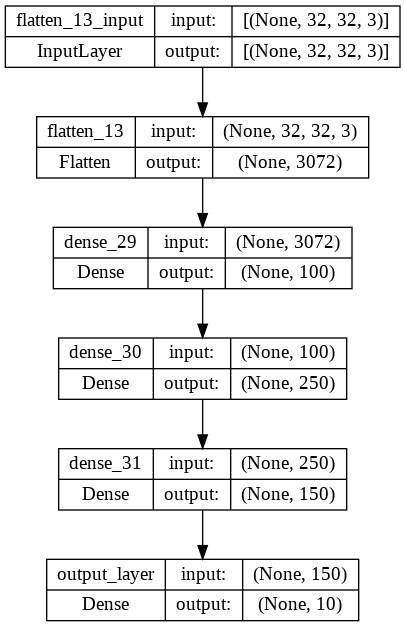

In [202]:
keras.utils.plot_model(model_5_2, "CIFAR_model.png", show_shapes=True) 

In [203]:
## Compile

model_5_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [204]:
## Train 

history_5_2 = model_5_2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 2.5068 - accuracy: 0.2946 - val_loss: 2.0076 - val_accuracy: 0.3404
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9868 - accuracy: 0.3314 - val_loss: 2.0072 - val_accuracy: 0.3152
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9397 - accuracy: 0.3446 - val_loss: 1.9374 - val_accuracy: 0.3318
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9070 - accuracy: 0.3555 - val_loss: 1.9162 - val_accuracy: 0.3498
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9046 - accuracy: 0.3549 - val_loss: 1.9050 - val_accuracy: 0.3540
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.8979 - accuracy: 0.3554 - val_loss: 1.9197 - val_accuracy: 0.3370
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.8842 - accuracy: 0.3592 - val_loss: 2.0070 - val_accuracy: 0.3308

In [205]:
## Evaluate

model_5_2 = tf.keras.models.load_model("DNN_model_5_2.h5")
print(f"Test acc: {model_5_2.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.8548 - accuracy: 0.3649
Test acc: 0.365


#### Model 5.3

Same as model 3 with regulaization

In [206]:
## Build CNN

model_5_3 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.3), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.3), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_5_3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 6, 6, 256)       

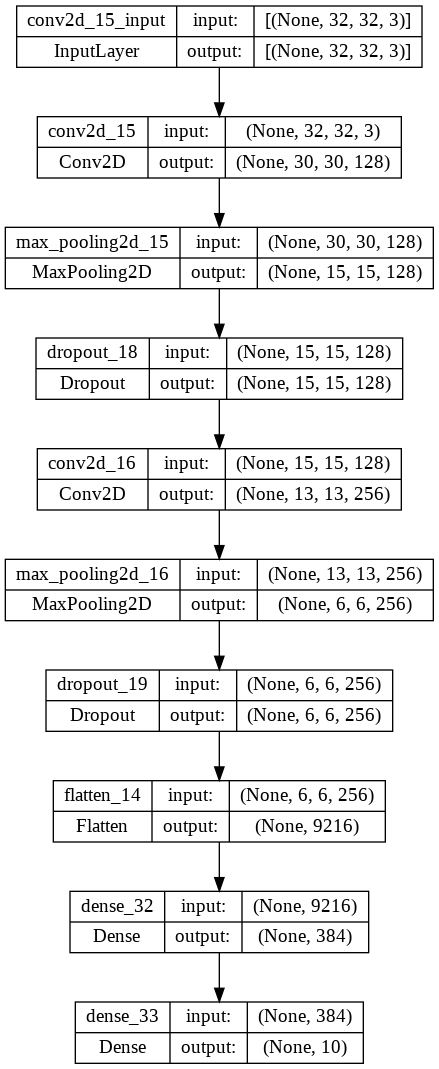

In [207]:
keras.utils.plot_model(model_5_3, "CIFAR10.png", show_shapes=True) 

In [208]:
## Compile

model_5_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [209]:
## Train 

history_5_3 = model_5_3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_3.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 8s 11ms/step - loss: 2.1473 - accuracy: 0.2152 - val_loss: 2.0808 - val_accuracy: 0.2090
Epoch 2/200
704/704 [==============================] - 8s 11ms/step - loss: 1.9467 - accuracy: 0.2458 - val_loss: 1.8809 - val_accuracy: 0.2468
Epoch 3/200
704/704 [==============================] - 8s 11ms/step - loss: 1.8434 - accuracy: 0.2611 - val_loss: 1.8229 - val_accuracy: 0.2692
Epoch 4/200
704/704 [==============================] - 8s 11ms/step - loss: 1.7788 - accuracy: 0.2765 - val_loss: 1.7585 - val_accuracy: 0.2802
Epoch 5/200
704/704 [==============================] - 7s 11ms/step - loss: 1.7310 - accuracy: 0.2893 - val_loss: 1.7093 - val_accuracy: 0.2956
Epoch 6/200
704/704 [==============================] - 7s 10ms/step - loss: 1.6939 - accuracy: 0.3003 - val_loss: 1.7350 - val_accuracy: 0.3114
Epoch 7/200
704/704 [==============================] - 7s 11ms/step - loss: 1.6502 - accuracy: 0.3356 - val_loss: 1.6380 - val_accuracy:

In [210]:
## Evaluate

model_5_3 = tf.keras.models.load_model("CNN_model_5_3.h5")
print(f"Test acc: {model_3.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.1218 - accuracy: 0.6620
Test acc: 0.662


#### Model 5.4 
Same as Model 4 with regularization

In [233]:
## Build CNN

model_5_4 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])
model_5_4.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 6, 6, 256)       

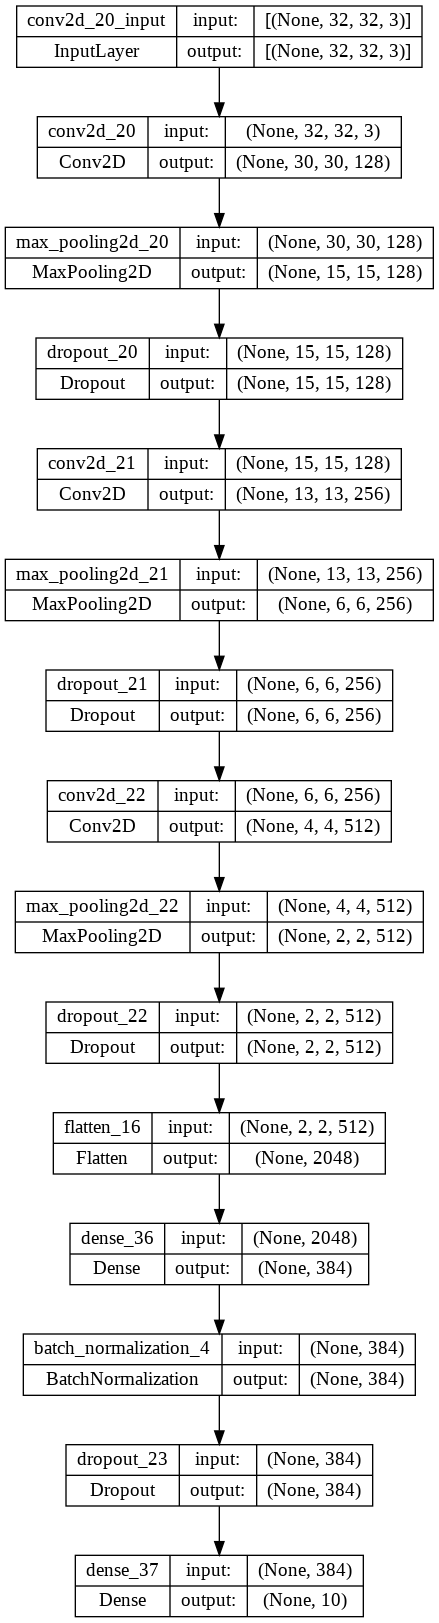

In [234]:
keras.utils.plot_model(model_5_4, "CIFAR10.png", show_shapes=True) 

In [235]:
## Compile
model_5_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [238]:
## Train
history_5_4 = model_5_4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_4.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 9s 13ms/step - loss: 1.2004 - accuracy: 0.6100 - val_loss: 1.2088 - val_accuracy: 0.5934
Epoch 2/200
704/704 [==============================] - 9s 13ms/step - loss: 1.1031 - accuracy: 0.6472 - val_loss: 1.0121 - val_accuracy: 0.6804
Epoch 3/200
704/704 [==============================] - 9s 13ms/step - loss: 1.0281 - accuracy: 0.6769 - val_loss: 0.9285 - val_accuracy: 0.7142
Epoch 4/200
704/704 [==============================] - 9s 12ms/step - loss: 0.9703 - accuracy: 0.6994 - val_loss: 0.9610 - val_accuracy: 0.6888
Epoch 5/200
704/704 [==============================] - 9s 12ms/step - loss: 0.9348 - accuracy: 0.7132 - val_loss: 0.8780 - val_accuracy: 0.7220
Epoch 6/200
704/704 [==============================] - 9s 12ms/step - loss: 0.8967 - accuracy: 0.7251 - val_loss: 0.8943 - val_accuracy: 0.7140
Epoch 7/200
704/704 [==============================] - 9s 12ms/step - loss: 0.8655 - accuracy: 0.7346 - val_loss: 0.8276 - val_accuracy:

In [240]:
## Evalute

model_5_4 = tf.keras.models.load_model("CNN_model_5_4.h5")
print(f"Test acc: {model_4.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 6ms/step - loss: 0.8122 - accuracy: 0.7563
Test acc: 0.756
